# Task

**Описание задания:**

В домашнем задании нужно решить задачу классификации точек наиболее эффективно. Для этого в работе необходимо применить различные методы по отбору признаков. Отбор признаков предпочтительнее осуществлять основываясь на математическом аппарате, поэтому данные для этого задания будут сгенерированы, чтобы избежать признаков с физическим смыслом.

**Этапы работы:**

1. Сгенерируйте данные с помощью кода:

from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification(scale=1)

2. Постройте модель логистической регрессии и оцените среднюю точность. Для этого используйте следующий код:

cross_val_score(LogisticRegression(), x, y, scoring=‘accuracy’).mean()

3. Используйте статистические методы для отбора признаков:

a) Выберите признаки на основе матрицы корреляции.

b) Отсеките низковариативные признаки (VarianceThreshold).

c) Повторите п. 2 на отобранных признаках в п. 3a, п. 3b.

4. Осуществите отбор признаков на основе дисперсионного анализа:

a) Выберите 5 лучших признаков с помощью скоринговой функции для классификации f_classif (SelectKBest(f_classif, k=5)).

b) Повторите п. 2 на отобранных признаках.

5. Отбор с использованием моделей:

a) Реализуйте отбор признаков с помощью логистической регрессии. Отобранные признаки подайте далее на вход в саму логистическую регрессию (SelectFromModel). Используйте L1 регуляризацию.

b) Реализуйте отбор признаков с помощью модели RandomForest и встроенного атрибута feature_impotance.

c) Повторите п. 2 на отобранных признаках в п. 5a, п. 5b.

Перебор признаков:

a) SequentialFeatureSelector.

b) Повторите п. 2 на отобранных признаках.

6. Сформулируйте выводы по проделанной работе:

a) Сделайте таблицу вида |способ выбора признаков|количество признаков|средняя точность модели|.

# Library

In [343]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector

In [344]:
SEED = 42

# Create data

In [345]:
x_data_generated, y_data_generated = make_classification(scale=1, random_state=SEED)

In [346]:
x_data_generated.shape, y_data_generated.shape

((100, 20), (100,))

# Modeling_1 and scoring

In [347]:
cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='accuracy').mean()

0.9800000000000001

In [348]:
data = {'Feature selection method':['Not selection'], 'Number of features': [20], 'Average accuracy': [0.9800000000000001]}
df = pd.DataFrame(data=data)

# Feature selection (statistical)

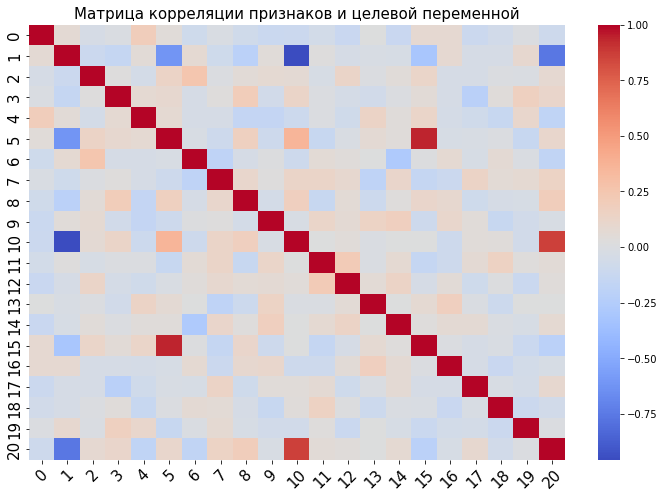

In [349]:
matrix_X_y = np.c_[x_data_generated, y_data_generated]
plt.rcParams["figure.figsize"] = (12, 8)
sns.heatmap(pd.DataFrame(matrix_X_y).corr(),cmap='coolwarm', annot=False)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Матрица корреляции признаков и целевой переменной', fontsize=15)
plt.show()

Сильно скоррелированы признаки:

1. 5 и 1
2. 15 и 5
3. 10 и 1

Уберем корреляции между признаками, оставив те признаки, которые имеют наибольшую корреляцию с целевой переменной

Отсортируем по коэффициенту корреляциис целевой переменной признаки

In [350]:
np.abs(pd.DataFrame(matrix_X_y).corr().iloc[-1, :]).sort_values(ascending=False)

20    1.000000
10    0.864791
1     0.763444
15    0.202191
8     0.195757
4     0.172387
6     0.166805
7     0.146512
3     0.118718
5     0.108329
17    0.096357
0     0.088754
2     0.088433
14    0.082213
18    0.063914
11    0.056474
12    0.037922
16    0.024239
9     0.023958
13    0.017637
19    0.003071
Name: 20, dtype: float64

Уберм из рассмотрения признаки: 1, 5

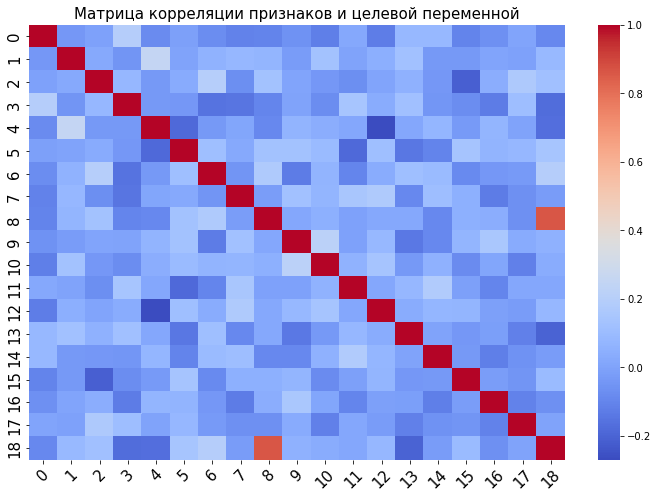

In [351]:
matrix_X_y = np.c_[x_data_generated, y_data_generated]
matrix_X_y_not_corr = np.delete(matrix_X_y, [1, 5], axis=1)

plt.rcParams["figure.figsize"] = (12, 8)
sns.heatmap(pd.DataFrame(matrix_X_y_not_corr).corr(),cmap='coolwarm', annot=False)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Матрица корреляции признаков и целевой переменной', fontsize=15)
plt.show()

Отсекаем низковариативные признаки (VarianceThreshold).

In [352]:
matrix_X_not_corr = matrix_X_y_not_corr[:, :-1]
matrix_y_not_corr = matrix_X_y_not_corr[:, -1]

In [353]:
matrix_X_not_corr = VarianceThreshold().fit_transform(matrix_X_not_corr)
matrix_X_not_corr.shape


(100, 18)

Низковариативных признаков не оказалось

Построим модель на обновленных признаках

# Modeling_2 and scoring

In [354]:
cross_val_score(LogisticRegression(), matrix_X_not_corr, matrix_y_not_corr, scoring='accuracy').mean()

0.96

In [355]:
data = {'Feature selection method':['Statistical'], 'Number of features': [18], 'Average accuracy': [0.96]}
df = pd.concat([df, pd.DataFrame(data=data)])

Осуществим отбор признаков на основе дисперсионного анализа

# Feature selection (Dispersive analysis)

In [356]:
selector_da = SelectKBest(f_classif, k=5)
matrix_X_not_corr_5_feature = selector_da.fit_transform(matrix_X_not_corr, matrix_y_not_corr)
selector_da.get_feature_names_out()

array(['x3', 'x4', 'x6', 'x8', 'x13'], dtype=object)

# Modeling_3 and scoring

In [357]:
cross_val_score(LogisticRegression(), matrix_X_not_corr_5_feature, matrix_y_not_corr, scoring='accuracy').mean()

0.9800000000000001

In [358]:
data = {'Feature selection method':['Dispersive analysis'], 'Number of features': [5], 'Average accuracy': [0.9800000000000001]}
df = pd.concat([df, pd.DataFrame(data=data)])

# Feature selection (SelectFromModel)


In [359]:
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                        solver='liblinear',
                                                        random_state=SEED))
matrix_X_logreg_feature = selector.fit_transform(matrix_X_not_corr, matrix_y_not_corr)
selector.get_feature_names_out()

array(['x2', 'x5', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x16'],
      dtype=object)

# Modeling_4 and scoring

In [360]:
cross_val_score(LogisticRegression(), matrix_X_logreg_feature, matrix_y_not_corr, scoring='accuracy').mean()

0.9800000000000001

In [361]:
data = {'Feature selection method':['SelectFromModel'], 'Number of features': [9], 'Average accuracy': [0.9800000000000001]}
df = pd.concat([df, pd.DataFrame(data=data)])

# Feature selection (RandomForest)

In [362]:
feature_select = RandomForestClassifier(random_state=SEED)
feature_select.fit(matrix_X_not_corr, matrix_y_not_corr)
feature_select.feature_importances_

array([0.02793011, 0.01834036, 0.02767327, 0.04274861, 0.03444497,
       0.0314429 , 0.03692949, 0.02299216, 0.49967066, 0.02693947,
       0.02557101, 0.02231831, 0.01995619, 0.05942854, 0.02223004,
       0.02637931, 0.02139755, 0.03360705])

In [363]:
df_feature_importances = pd.concat([pd.DataFrame(matrix_X_not_corr).T,
                                    pd.DataFrame(feature_select.feature_importances_, columns=['feature_importances'])
                                    ], axis=1)
df_feature_importances = df_feature_importances[['feature_importances']].sort_values('feature_importances', ascending=False)
df_feature_importances.style.bar('feature_importances', align='mid')

,feature_importances
8,0.499671
13,0.059429
3,0.042749
6,0.036929
4,0.034445
17,0.033607
5,0.031443
0,0.027930
2,0.027673
9,0.026939


Возьмем для модели 5 самых важных признаков

# Modeling_5 and scoring

In [364]:
cross_val_score(LogisticRegression(), pd.DataFrame(matrix_X_not_corr)[[8,13,3,6,4]], matrix_y_not_corr, scoring='accuracy').mean()

0.9800000000000001

In [365]:
data = {'Feature selection method':['RandomForest'], 'Number of features': [5], 'Average accuracy': [0.9800000000000001]}
df = pd.concat([df, pd.DataFrame(data=data)])

Переберем признаки

# Feature selection (SequentialFeatureSelector)

In [366]:
sfs = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=3)
matrix_X_not_corr_5_feature_sfs = sfs.fit_transform(matrix_X_not_corr, matrix_y_not_corr)
sfs.get_feature_names_out()

array(['x2', 'x8', 'x13'], dtype=object)

# Modeling_6 and scoring

In [367]:
cross_val_score(LogisticRegression(), matrix_X_not_corr_5_feature_sfs, matrix_y_not_corr, scoring='accuracy').mean()

1.0

In [368]:
data = {'Feature selection method':['SequentialFeatureSelector'], 'Number of features': [3], 'Average accuracy': [1.0]}
df = pd.concat([df, pd.DataFrame(data=data)])

# Resume

In [369]:
df.reset_index(drop=True)

,Feature selection method,Number of features,Average accuracy
0,Not selection,20,0.98
1,Statistical,18,0.96
2,Dispersive analysis,5,0.98
3,SelectFromModel,9,0.98
4,RandomForest,5,0.98
5,SequentialFeatureSelector,3,1.00
